<h1 align="center" style="font-variant: small-caps">How to build a genome-scale self-replicating cell model</h1>
<h2 align="center">TUTORIAL 3 &mdash; Edit and compress the model</h2>
<h5 align="center">(<code>Version 16</code>, August 2025)</h5>

<div align="center" style="max-width:200px;display:block;margin:auto;">

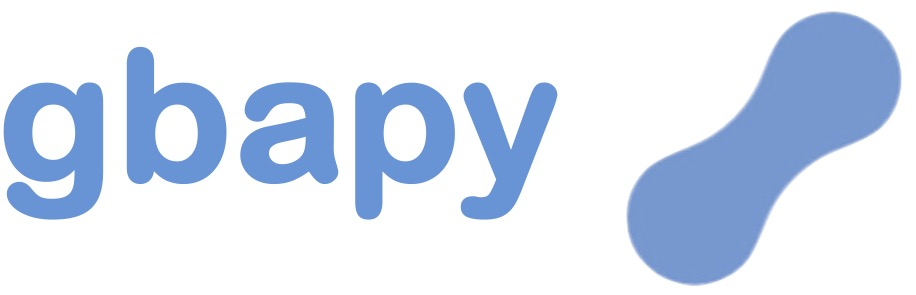

</div>

# Table of contents <a id="table_of_contents"></a>

- [1. Objective](#objective)
- [2. Load the CGM builder](#load)
- [3. Rename all metabolites based on GBA formalism](#rename)
- [4. Compress amino-acids and tRNAs metabolism](#AA_edit)
  - [4.1. Collect the list of metabolites and reactions of interest](#AA_edit_1)
  - [4.2. Collect proteins associated to each group of reactions](#AA_edit_2)
  - [4.3. Delete the polypeptides pathway](#AA_edit_3)
  - [4.4. Calculate average amino-acids and tRNAs](#AA_edit_4)
  - [4.5. Create pseudo-reactions](#AA_edit_5)
  - [4.6. Delete original amino-acid and tRNAs pathways](#AA_edit_6)
  - [4.7. Remove or edit dependent pathways](#AA_edit_7)
- [5. Edit proteins synthesis reaction](#protein_edit)
- [6. Remove alternative sugar transporters](#sugar_edit)
- [7. Final model check and backup](#check)

# In summary

<div align="center" style="max-width:850px;display:block;margin:auto;">

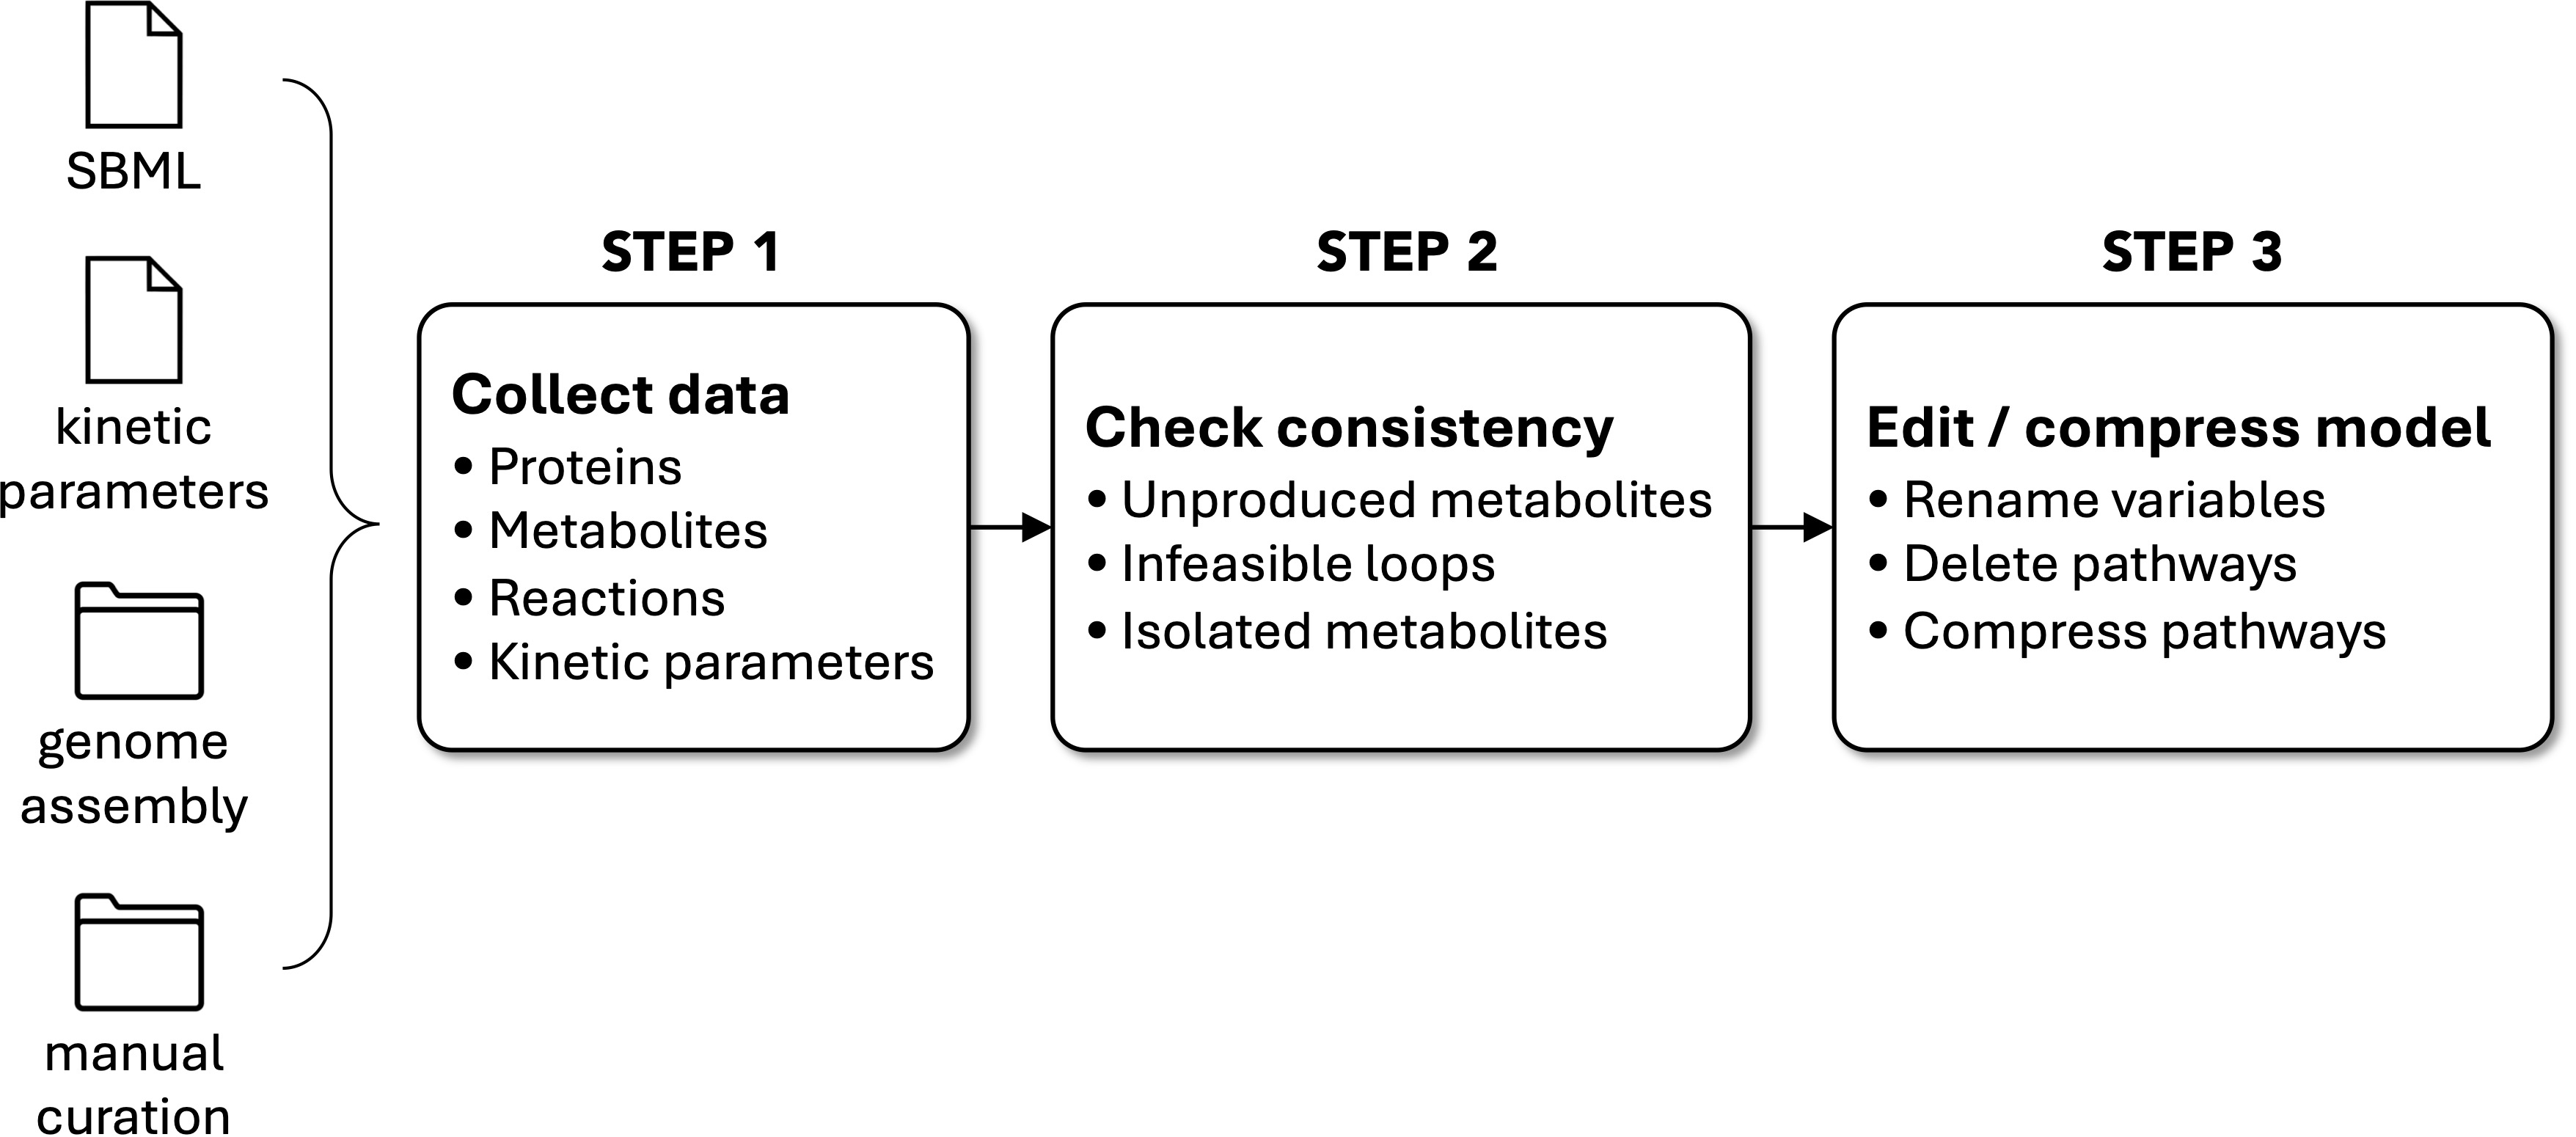

</div>

<div align="center">
<br/><br/>
<strong>&rarr; At each step of this tutorial, the GBApy methods used are listed</strong>.
</div>

# 1. Objective <a id="objective"></a>

[&#10148; Back to the table of contents](#table_of_contents)

During the tutorials 1 and 2, we have collected all the necessary data (tutorial 1), and checked for structural and mass conservation errors (tutorial 2).
We will now bring some adjustments to the model and reduce its complexity.

$\bullet$ <strong>First,</strong> we will rename metabolites to fit GBA formalism (external metabolites must have a prefix `x_`; internal metabolite suffixes `_c` are removed).

$\bullet$ <strong>Second,</strong> we will operate an important simplification of the amino-acid and tRNA metabolism by reducing these metabolites to single pseudo-molecules, which will further facilitate the solving and the analysis of the model.

$\bullet$ <strong>Third, </strong> a few modifications are required to obtain a working CGM:
- <strong>(1)</strong> Edit the ribosomal reaction for protein synthesis. This reaction must be named `Ribosome` and produce the metabolite `Protein`. A protein synthesis reaction already exists in the MMSYN model: `Protein_transl`. However, we will have to edit the enzyme composition to fit the ribosome composition in proteins (listed in the genome assembly);
- <strong>(2)</strong> A few reactions should be removed, because they will never be used. This is the case of protein degradation (`Protein_degrad`) and the transport of alternative carbon sources.

In [1]:
import gba
import cobra
from Bio import SeqIO

# 2. Load the CGM builder <a id="load"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.load_builder( path )</code> | Load a CGM builder from a backup |

</div>

The GGM builder is loaded from the backup created in step 2.
We also re-load the original SBML model of a minimal cell.

In [2]:
builder    = gba.load_builder("backup/mmsyn_build_2.cgmbuild")
sbml_model = cobra.io.read_sbml_model("data/manual_curation/MMSYN_annotated.xml")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-15
Read LP format model from file /var/folders/5h/n0xqh1xj2zg6yyd747k95bc80000gn/T/tmpai5zvzsm.lp
Reading time = 0.00 seconds
: 279 rows, 670 columns, 3274 nonzeros


# 3. <a id="rename"></a> Rename all metabolites based on GBA formalism

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.rename_metabolite( previous_id, new_id )</code> | Rename a metabolite |

</div>

To fit GBA formalism, we must rename external and internal metabolites:
- External metabolites must have a prefix `x_`; we will also remove the suffix `_e`,
- We will remove the suffix `_c` for internal metabolites.

In [3]:
previous_ids = list(builder.metabolites.keys())
for m_id in previous_ids:
    new_id = m_id
    if new_id.endswith("_e"):
        new_id = "x_"+new_id[:-2]
        builder.rename_metabolite(m_id, new_id)
    elif new_id.endswith("_c"):
        new_id = new_id[:-2]
        builder.rename_metabolite(m_id, new_id)

# 4. Compress amino-acid and tRNA metabolism <a id="AA_edit"></a>

[&#10148; Back to the table of contents](#table_of_contents)

We will now considerably simplify the tRNA and amino-acid metabolism, by defining single pseudo-metabolites and pseudo-reactions, and by removing original reactions.

We will also get rid of the 19 polypeptides (L-Glutamine has no associated polypeptide) which are involved in two types of reactions (see figure below):
- Transporters (`Opp`),
- Conversion into amino-acids (`Peptidases`).

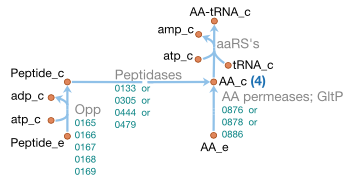

## 4.1. Collect the list of metabolites and reactions of interest <a id="AA_edit_1"></a>

[&#10148; Back to the table of contents](#table_of_contents)

In [4]:
# Polypeptide metabolism
external_polypeptides    = ["x_arg4", "x_asp4", "x_glu4", "x_gly4", "x_ile4", "x_ala4", "x_asn4", "x_leu4", "x_gln4", "x_his4", "x_lys4", "x_pro4", "x_phe4", "x_thr4", "x_trp4", "x_tyr4", "x_val4", "x_ser4", "x_met4"]
internal_polypeptides    = ["arg4", "asp4", "glu4", "gly4", "ile4", "ala4", "asn4", "leu4", "gln4", "his4", "lys4", "pro4", "phe4", "thr4", "trp4", "tyr4", "val4", "ser4", "met4"]
polypeptide_transporters = ["ARG4abc", "ASP4abc", "GLU4abc", "GLY4abc", "ISO4abc", "ALA4abc", "ASN4abc", "LEU4abc", "GLN4abc", "HIS4abc", "LYS4abc", "PRO4abc", "PHE4abc", "THR4abc", "TRP4abc", "TYR4abc", "VAL4abc", "SER4abc", "MET4abc"]
polypeptide_converters   = ["ARG4P", "ASP4P", "GLU4P", "GLY4P", "ISO4P", "ALA4P", "ASN4P", "LEU4P", "GLN4P", "HIS4P", "LYS4P", "PRO4P", "PHE4P", "THR4P", "TRP4P", "TYR4P", "VAL4P", "SER4P", "MET4P"]

# Amino-acid metabolism
# (Note: multi-pathway amino-acids: asn__L, asp__L, gln__L, glu__L, gly, lys__L, met__L, ser__L)
external_amino_acids    = ["x_ala__L", "x_arg__L", "x_asn__L", "x_asp__L", "x_cys__L", "x_gln__L", "x_glu__L", "x_gly", "x_his__L", "x_ile__L", "x_leu__L", "x_lys__L", "x_met__L", "x_phe__L", "x_pro__L", "x_ser__L", "x_thr__L", "x_trp__L", "x_tyr__L", "x_val__L"]
internal_amino_acids    = ["ala__L", "arg__L", "asn__L", "asp__L", "cys__L", "gln__L", "glu__L", "gly", "his__L", "ile__L", "leu__L", "lys__L", "met__L", "phe__L", "pro__L", "ser__L", "thr__L", "trp__L", "tyr__L", "val__L"]
amino_acid_transporters = ["ALAt2r", "ARGt2r", "ASNt2r", "ASPt2pr", "CYSt2r", "GLNt2r", "GLUt2pr", "GLYt2r", "HISt2r", "ISOt2r", "LEUt2r", "LYSt2r", "METt2r", "PHEt2r", "PROt2r", "SERt2r", "THRt2r", "TRPt2r", "TYRt2r", "VALt2r"]

# tRNA metabolism
# (Note: one multi-pathway uncharged tRNA: trnagln_c)
# (Note: two multi-pathway charged tRNAs: glntrna_c and mettrna_c)
uncharged_trnas      = ["trnaala", "trnaarg", "trnaasn", "trnaasp", "trnacys", "trnagln", "trnaglu", "trnagly", "trnahis", "trnaile", "trnaleu", "trnalys", "trnamet", "trnaphe", "trnapro", "trnaser", "trnathr", "trnatrp", "trnatyr", "trnaval"]
charged_trnas        = ["alatrna", "argtrna", "asntrna", "asptrna", "cystrna", "glntrna", "glutrna", "glytrna","histrna", "iletrna", "leutrna", "lystrna", "mettrna", "phetrna", "protrna", "sertrna", "thrtrna", "trptrna", "tyrtrna", "valtrna"]
production_reactions = ["trnaalaP", "trnaargP", "trnaasnP", "trnaaspP", "trnacysP", "trnaglnP", "trnagluP", "trnaglyP", "trnahisP", "trnaileP", "trnaleuP", "trnalysP", "trnametP", "trnapheP", "trnaproP", "trnaserP", "trnathrP", "trnatrpP", "trnatyrP", "trnavalP"]
charging_reactions   = ["ALATRS", "ARGTRS", "ASNTRS", "ASPTRS", "CYSTRS", "GLUTRS", "GLYTRS", "HISTRS", "ILETRS", "LEUTRS", "LYSTRS", "METTRS", "PHETRS", "PROTRS", "SERTRS", "THRTRS", "TRPTRS", "TYRTRS", "VALTRS"]

## 4.2. Collect proteins associated to each group of reactions <a id="AA_edit_2"></a>

[&#10148; Back to the table of contents](#table_of_contents)

For each group of reactions, we will collect the list of proteins to report them in the pseudo-reactions (except for the polypeptide metabolism which will be removed).

In [5]:
# Amino-acid transporters proteins
amino_acid_transporters_proteins = {}
contribution_sum                 = 0.0
for r_id in amino_acid_transporters:
    for p_id, contrib in builder.reactions[r_id].proteins.items():
        if p_id not in amino_acid_transporters_proteins:
            amino_acid_transporters_proteins[p_id] = contrib
        else:
            amino_acid_transporters_proteins[p_id] += contrib
        contribution_sum += contrib
amino_acid_transporters_proteins = {p_id: contrib/contribution_sum for p_id, contrib in amino_acid_transporters_proteins.items()}

# tRNA production proteins
trna_production_proteins = {}
contribution_sum         = 0.0
for r_id in production_reactions:
    for p_id, contrib in builder.reactions[r_id].proteins.items():
        if p_id not in trna_production_proteins:
            trna_production_proteins[p_id] = contrib
        else:
            trna_production_proteins[p_id] += contrib
        contribution_sum += contrib
trna_production_proteins = {p_id: contrib/contribution_sum for p_id, contrib in trna_production_proteins.items()}

# tRNA charging proteins
trna_charging_proteins = {}
contribution_sum       = 0.0
for r_id in charging_reactions:
    for p_id, contrib in builder.reactions[r_id].proteins.items():
        if p_id not in trna_charging_proteins:
            trna_charging_proteins[p_id] = contrib
        else:
            trna_charging_proteins[p_id] += contrib
        contribution_sum += contrib
trna_charging_proteins = {p_id: contrib/contribution_sum for p_id, contrib in trna_charging_proteins.items()}

## 4.3. Delete the polypeptides pathway <a id="AA_edit_3"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.remove_reaction()</code> | Remove a reaction from the CGM builder |
| <code>gba.Builder.remove_metabolite()</code> | Remove a metabolite from the CGM builder |
| <code>gba.Builder.check_model( test_structure )</code> | Check connectivity issues in the model |

</div>

In [6]:
builder.remove_metabolites(external_polypeptides)
builder.remove_metabolites(internal_polypeptides)
builder.remove_reactions(polypeptide_transporters)
builder.remove_reactions(polypeptide_converters)

In [7]:
builder.check_model(test_structure=True)

❯ Info,No missing mass in the model.


❯ Info,No missing kinetic parameters in the model.


❯ Info,No connectivity issues in the model.


❯ Info,No unproduced metabolites in the model.


❯ Info,No infeasible loops in the model.


❯ Info,No isolated metabolites in the model.


## 4.3. Calculate average amino-acids and tRNAs <a id="AA_edit_3"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Metabolite(id, name, species_location, species_type, formula, annotation )</code> | Constructor of the class <code>gba.Metabolite</code> |
| <code>gba.Metabolite.calculate_mass()</code> | Calculate the mass of a metabolite |
| <code>gba.Builder.add_metabolite( metabolite )</code> | Add a metabolite to the CGM builder |
| <code>gba.Metabolite.summary()</code> | Display a summary of the metabolite |

</div>

We now have to calculate:
- An average amino-acid,
- An average uncharged tRNA from tRNA sequences,
- An average charged tRNA by summing the mass of the average uncharged tRNA and the average amino-acid.

In [8]:
# Calculate an average amino-acid
average_AA_mass = 0.0
for aa_id in internal_amino_acids:
    average_AA_mass += builder.metabolites[aa_id].mass
average_AA_mass /= len(internal_amino_acids)

x_AA = gba.Metabolite(id="x_AA", name="Average external amino-acid",
                      species_location=gba.SpeciesLocation.External,
                      species_type=gba.SpeciesType.SmallMolecule,
                      formula="", mass=average_AA_mass)
AA = gba.Metabolite(id="AA", name="Average internal amino-acid",
                    species_location=gba.SpeciesLocation.Internal,
                    species_type=gba.SpeciesType.SmallMolecule,
                    formula="", mass=average_AA_mass)
builder.add_metabolite(x_AA)
builder.add_metabolite(AA)
builder.metabolites["x_AA"].summary()
builder.metabolites["AA"].summary()

# Calculate average uncharged/charged tRNAs
n_atp = 0.0
n_ctp = 0.0
n_gtp = 0.0
n_utp = 0.0
count = 0.0
for m_id in uncharged_trnas:
    seq     = builder.metabolites[m_id].formula
    n_atp  += seq.count("A")
    n_ctp  += seq.count("C")
    n_gtp  += seq.count("G")
    n_utp  += seq.count("U")
    count  += 1.0
n_atp       = int(n_atp/count)
n_ctp       = int(n_ctp/count)
n_gtp       = int(n_gtp/count)
n_utp       = int(n_utp/count)
average_seq = "A" * n_atp + "C" * n_ctp + "G" * n_gtp + "U" * n_utp
tRNA = gba.Metabolite(id="tRNA", name="Average uncharged tRNA",
                      species_location=gba.SpeciesLocation.Internal,
                      species_type=gba.SpeciesType.RNA,
                      formula=average_seq)
tRNA.calculate_mass()
AAtRNA = gba.Metabolite(id="AAtRNA", name="Average charged tRNA",
                        species_location=gba.SpeciesLocation.Internal,
                        species_type=gba.SpeciesType.RNA,
                        formula="", mass=tRNA.mass+average_AA_mass)
builder.add_metabolite(tRNA)
builder.add_metabolite(AAtRNA)
builder.metabolites["tRNA"].summary()
builder.metabolites["AAtRNA"].summary()

,x_AA
Name,Average external amino-acid
Location,External
Type,Small molecule
Formula,-
Mass,136.900419


,AA
Name,Average internal amino-acid
Location,Internal
Type,Small molecule
Formula,-
Mass,136.900419


,tRNA
Name,Average uncharged tRNA
Location,Internal
Type,RNA
Formula,AAAAAAAAAAAAAAAACCCC...
Mass,24493.4535


,AAtRNA
Name,Average charged tRNA
Location,Internal
Type,RNA
Formula,-
Mass,24630.353919


## 4.4. Create pseudo-reactions <a id="AA_edit_4"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Reaction(id, name, reaction_type, lb, ub, metabolites, proteins, GPR, enzyme_mass )</code> | Constructor of the class <code>gba.Reaction</code> |
| <code>gba.Reaction.complete_kcat_values( value )</code> | Fill missing $k_\text{cat}$ values with a given value |
| <code>gba.Reaction.complete_km_values( value )</code> | Fill missing $K_\text{M}$ values with a given value |
| <code>gba.Builder.add_metabolite( metabolite )</code> | Add a metabolite to the CGM builder |
| <code>gba.Builder.add_reaction( reaction )</code> | Add a reaction to the CGM builder |
| <code>gba.Reaction.summary()</code> | Display a summary of the reaction |
| <code>gba.Builder.check_model( test_structure )</code> | Check connectivity issues in the model |

</div>

We will now create pseudo-reactions for the amino-acid metabolism:
- A transporter for the average amino-acid,
- A charging reaction for the average uncharged tRNA.

In [9]:
# Average amino-acid transporter
stoichiometry = {
    "x_AA": -1,
    "atp": -1,
    "h2o": -1,
    "AA": 1,
    "adp": 1,
    "h": 1,
    "pi": 1
}
reaction = gba.Reaction(id="AAabc", name="Average amino-acid transporter",
                        reaction_type=gba.ReactionType.Transport,
                        lb=0.0, ub=1000.0,
                        metabolites=stoichiometry,
                        proteins=amino_acid_transporters_proteins,
                        GPR=gba.ReactionGPR.AND)
reaction.enforce_kcat_irreversibility()
reaction.enforce_km_irreversibility()
reaction.complete(kcat_value=45000.0, km_value=0.00013)
builder.add_reaction(reaction)
builder.reactions["AAabc"].summary()

# Average tRNA synthesis
seq      = builder.metabolites["tRNA"].formula
n_atp    = seq.count("A")
n_ctp    = seq.count("C")
n_gtp    = seq.count("G")
n_utp    = seq.count("U")
n_ppi    = n_atp+n_ctp+n_gtp+n_utp
atp_cost = int(n_ppi*0.41)
stoichiometry = {
    "atp": -n_atp-atp_cost,
    "ctp": -n_ctp,
    "gtp": -n_gtp,
    "utp": -n_utp,
    "h2o": -atp_cost,
    "tRNA": 1,
    "adp": atp_cost,
    "h": atp_cost,
    "pi": atp_cost,
    "ppi": n_ppi
}
reaction = gba.Reaction(id="tRNAP", name="tRNA polymerase reaction",
                        reaction_type=gba.ReactionType.Metabolic,
                        lb=0.0, ub=1000.0,
                        metabolites=stoichiometry,
                        proteins=trna_production_proteins,
                        GPR=gba.ReactionGPR.AND)
reaction.enforce_kcat_irreversibility()
reaction.enforce_km_irreversibility()
reaction.complete(kcat_value=45000.0, km_value=0.00013)
builder.add_reaction(reaction)
builder.reactions["tRNAP"].summary()

# Average tRNA charging reaction
stoichiometry = {
    "AA": -1,
    "tRNA": -1,
    "atp": -1,
    "AAtRNA": 1,
    "amp": 1,
    "ppi": 1
}
reaction = gba.Reaction(id="AATRS", name="Average tRNA charging reaction",
                        reaction_type=gba.ReactionType.Metabolic,
                        lb=0.0, ub=1000.0,
                        metabolites=stoichiometry,
                        proteins=trna_charging_proteins,
                        GPR=gba.ReactionGPR.AND)
reaction.enforce_kcat_irreversibility()
reaction.enforce_km_irreversibility()
reaction.complete(kcat_value=45000.0, km_value=0.00013)
builder.add_reaction(reaction)
builder.reactions["AATRS"].summary()

,AAabc
Name,Average amino-acid transporter
Type,Transport
Stoichiometry,x_AA + atp + h2o --> AA + adp + h + pi
Lower bound,0.0
Upper bound,1000.0
Enzyme mass,57167.561689
GPR,AND
Proteins,0.47368421052631576 protein_0876 + 0.47368421052631576 protein_0878 + 0.05263157894736842 protein_0886
Forward kcat,45000.0
Backward kcat,0.0


,tRNAP
Name,tRNA polymerase reaction
Type,Metabolic
Stoichiometry,47 atp + 21 ctp + 22 gtp + 17 utp + 31 h2o --> tRNA + 31 adp + 31 h + 31 pi + 76 ppi
Lower bound,0.0
Upper bound,1000.0
Enzyme mass,104460.022681
GPR,AND
Proteins,1.0 average_protein
Forward kcat,45000.0
Backward kcat,0.0


,AATRS
Name,Average tRNA charging reaction
Type,Metabolic
Stoichiometry,AA + tRNA + atp --> AAtRNA + amp + ppi
Lower bound,0.0
Upper bound,1000.0
Enzyme mass,62869.976255
GPR,AND
Proteins,0.03225806451612903 protein_0163 + 0.03225806451612903 protein_0535 + 0.06451612903225806 protein_0076 + 0.06451612903225806 protein_0287 + 0.03225806451612903 protein_0837 + 0.03225806451612903 protein_0126 + 0.06451612903225806 protein_0405 + 0.06451612903225806 protein_0288 + 0.03225806451612903 protein_0519 + 0.03225806451612903 protein_0634 + 0.06451612903225806 protein_0064 + 0.03225806451612903 protein_0012 + 0.06451612903225806 protein_0528 + 0.03225806451612903 protein_0529 + 0.06451612903225806 protein_0282 + 0.06451612903225806 protein_0061 + 0.06451612903225806 protein_0222 + 0.06451612903225806 protein_0308 + 0.06451612903225806 protein_0613 + 0.03225806451612903 protein_0260
Forward kcat,45000.0
Backward kcat,0.0


In [10]:
builder.check_model(test_structure=True)

❯ Info,No missing mass in the model.


❯ Info,No missing kinetic parameters in the model.


❯ Info,No connectivity issues in the model.


❯ Info,No unproduced metabolites in the model.


❯ Info,No infeasible loops in the model.


❯ Info,No isolated metabolites in the model.


The tRNA molecule appears to be unproduced, but this problem will be solved when editing the protein synthesis reaction (see below).

## 4.5. Delete original amino-acid and tRNAs pathways <a id="AA_edit_5"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.remove_reaction()</code> | Remove a reaction from the CGM builder |
| <code>gba.Builder.remove_metabolite()</code> | Remove a metabolite from the CGM builder |
| <code>gba.Builder.check_model( test_structure )</code> | Check connectivity issues in the model |

</div>

To remove the original pathways, we will delete all 40 internal and external amino-acids, as well as uncharged/charged tRNAs.

In [11]:
builder.remove_metabolites(external_amino_acids)
builder.remove_metabolites(internal_amino_acids)
builder.remove_reactions(amino_acid_transporters)

builder.remove_metabolites(uncharged_trnas)
builder.remove_metabolites(charged_trnas)
builder.remove_reactions(production_reactions)
builder.remove_reactions(charging_reactions)

In [12]:
builder.check_model(test_structure=True)

❯ Info,No missing mass in the model.


❯ Info,No missing kinetic parameters in the model.


❯ Info,No connectivity issues in the model.


❯ Info,No unproduced metabolites in the model.


❯ Info,No infeasible loops in the model.


❯ Info,No isolated metabolites in the model.


## 4.6. Remove or edit dependent pathways <a id="AA_edit_6"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.remove_reaction()</code> | Remove a reaction from the CGM builder |
| <code>gba.Builder.remove_metabolite()</code> | Remove a metabolite from the CGM builder |
| <code>gba.Builder.check_model( test_structure )</code> | Check connectivity issues in the model |

</div>

We have to reconstruct the amino-acid metabolism by:
- Deleting pathways becoming useless or unapplicable after the simplification,
- Editing existent reactions including amino-acids or tRNAs.

Here are the pathways to delete:
- L-glutamyl-tRNA(Gln) metabolism, relying on a TRNA(Gln) to produce other charged tRNAs. As we use average pseudo-tRNAs, this pathway is now useless.

In [13]:
# Remove L-glutamyl-tRNA(Gln) pathways
builder.remove_reactions(["GLUTRS_Gln", "GLNTRAT", "GLNTRAT2"])
builder.remove_metabolite("glutrnagln")
builder.check_model(test_structure=True)

❯ Info,No missing mass in the model.


❯ Info,No missing kinetic parameters in the model.


❯ Info,No connectivity issues in the model.


❯ Info,No unproduced metabolites in the model.


❯ Info,No infeasible loops in the model.


❯ Info,No isolated metabolites in the model.


All the pathways linked to protein synthesis must be edited:
- ACP, PdhC and dUTPAse and protein synthesis,
- LIPTA (PdhC metabolism involving a lysine),
- FMETTRS (conversion of tRNA(Met) into N-formylmethionyl-tRNA(Met))

We will edit each of these pathways:

In [14]:
# ACP translation consumes 72 charged tRNAs (excluding fmettrna) and produces 73 uncharged tRNAs
builder.reactions["ACP_transl"].add_metabolites({"AAtRNA": -72, "tRNA": 73})
builder.reactions["ACP_transl"].complete(kcat_value=45000.0, km_value=0.00013)
builder.reactions["ACP_transl"].summary()

,ACP_transl
Name,ACP protein translation
Type,Metabolic
Stoichiometry,169.0 atp + fmettrna + 172.0 h2o + 72 AAtRNA --> 169.0 adp + apoACP + for + 242.0 h + 169.0 pi + 73 tRNA
Lower bound,0.0
Upper bound,1000.0
Enzyme mass,59691.9216
GPR,AND
Proteins,1.0 protein_0201 + 1.0 protein_0621 + 1.0 protein_0650
Forward kcat,45000
Backward kcat,0.0


In [15]:
# PdhC translation consumes 440 charged tRNAs (excluding fmettrna) and produces 441 uncharged tRNAs
builder.reactions["PdhC_transl"].add_metabolites({"AAtRNA": -440, "tRNA": 441})
builder.reactions["PdhC_transl"].complete(kcat_value=45000.0, km_value=0.00013)
builder.reactions["PdhC_transl"].summary()

,PdhC_transl
Name,PdhC protein translation
Type,Metabolic
Stoichiometry,1023.0 atp + fmettrna + 1025.0 h2o + 440 AAtRNA --> PdhC + 1023.0 adp + for + 1464.0 h + 1023.0 pi + 441 tRNA
Lower bound,0.0
Upper bound,1000.0
Enzyme mass,70276.9525
GPR,AND
Proteins,1.0 protein_0201 + 1.0 protein_0227
Forward kcat,45000
Backward kcat,0.0


In [16]:
# dUTPase translation consumes 166 charged tRNAs (excluding fmettrna) and produces 167 uncharged tRNAs
builder.reactions["dUTPase_transl"].add_metabolites({"AAtRNA": -166, "tRNA": 167})
builder.reactions["dUTPase_transl"].complete(kcat_value=45000.0, km_value=0.00013)
builder.reactions["dUTPase_transl"].summary()

,dUTPase_transl
Name,dUTPase protein translation
Type,Metabolic
Stoichiometry,387.0 atp + fmettrna + 389.0 h2o + 166 AAtRNA --> 387.0 adp + dUTPase + for + 554.0 h + 387.0 pi + 167 tRNA
Lower bound,0.0
Upper bound,1000.0
Enzyme mass,43385.6411
GPR,AND
Proteins,1.0 protein_0201 + 1.0 protein_0447
Forward kcat,45000
Backward kcat,0.0


In [17]:
# Protein translation consumes 385 charged tRNA (excluding fmettrna) and produces 386 uncharged tRNA
builder.reactions["Protein_transl"].add_metabolites({"AAtRNA": -385, "tRNA": 386})
builder.reactions["Protein_transl"].complete(kcat_value=45000.0, km_value=0.00013)
builder.reactions["Protein_transl"].summary()

,Protein_transl
Name,Protein protein translation
Type,Metabolic
Stoichiometry,896.0 atp + fmettrna + 899.0 h2o + 385 AAtRNA --> 896.0 adp + for + 1282.0 h + 896.0 pi + protein + 386 tRNA
Lower bound,0.0
Upper bound,1000.0
Enzyme mass,51383.3683
GPR,AND
Proteins,1.0 protein_0201 + 1.0 protein_0650
Forward kcat,45000
Backward kcat,0.0


In [18]:
# LIPTA produces one amino-acid
builder.reactions["LIPTA"].add_metabolites({"AA": 1})
builder.reactions["LIPTA"].complete(kcat_value=45000.0, km_value=0.00013)
builder.reactions["LIPTA"].summary()

,LIPTA
Name,LIPTA
Type,Transport
Stoichiometry,PdhC + atp + h2o + x_lplys__L --> adp + h + lpl_PdhC + pi + AA
Lower bound,0.0
Upper bound,1000.0
Enzyme mass,73895.635
GPR,NONE
Proteins,1.0 protein_0401
Forward kcat,360000
Backward kcat,0.0


In [19]:
# FMETTRS consumes one charged tRNA
builder.reactions["FMETTRS"].add_metabolites({"AAtRNA": -1})
builder.reactions["FMETTRS"].complete(kcat_value=45000.0, km_value=0.00013)
builder.reactions["FMETTRS"].summary()

,FMETTRS
Name,Methionyl-tRNA formyltransferase
Type,Metabolic
Stoichiometry,10fthfglu3 + AAtRNA --> fmettrna + h + thfglu3
Lower bound,0.0
Upper bound,1000.0
Enzyme mass,35953.5671
GPR,NONE
Proteins,1.0 protein_0390
Forward kcat,36252.0
Backward kcat,0.0


# 5. Edit proteins synthesis reaction <a id="protein_edit"></a>

[&#10148; Back to the table of contents](#table_of_contents)

- <strong>First</strong>, we rename the reaction `Protein_transl` into `Ribosome`, and its product `protein` into `Protein`, to match GBA formalism.
- <strong>Second</strong>, we edit the enzyme composition to make the production of the ribosomal machinery more realistic. To do so, we will collect all the ribosomal proteins and tell the model that all proteins are required to build the enzyme (AND GPR association).
- <strong>Third</strong>, we will delete the protein degradation, which does not match GBA formalism.

In [20]:

# Edit names to match the GBA formalism
builder.rename_reaction("Protein_transl", "Ribosome")
builder.rename_metabolite("protein", "Protein")

# Edit the ribosome reaction enzyme composition
ribosome     = builder.reactions["Ribosome"]
ribosome.GPR = gba.ReactionGPR.AND
ribosome.proteins.clear()
for p in builder.proteins.values():
    if not p.product is None and "ribosom" in p.product.lower():
        ribosome.add_proteins({p.id: 1})
ribosome.calculate_enzyme_mass()
ribosome.summary()

# Remove protein degradation
builder.remove_reaction("Protein_degrad")

,Ribosome
Name,Protein protein translation
Type,Metabolic
Stoichiometry,896.0 atp + fmettrna + 899.0 h2o + 385 AAtRNA --> 896.0 adp + for + 1282.0 h + 896.0 pi + 386 tRNA + Protein
Lower bound,0.0
Upper bound,1000.0
Enzyme mass,1077613.3002
GPR,AND
Proteins,1 protein_0913 + 1 protein_0025 + 1 protein_0027 + 1 protein_0082 + 1 protein_0137 + 1 protein_0148 + 1 protein_0149 + 1 protein_0198 + 1 protein_0199 + 1 protein_0238 + 1 protein_0247 + 1 protein_0263 + 1 protein_0289 + 1 protein_0294 + 1 protein_0301 + 1 protein_0348 + 1 protein_0362 + 1 protein_0365 + 1 protein_0377 + 1 protein_0403 + 1 protein_0422 + 1 protein_0482 + 1 protein_0499 + 1 protein_0500 + 1 protein_0501 + 1 protein_0930 + 1 protein_0526 + 1 protein_0536 + 1 protein_0540 + 1 protein_0637 + 1 protein_0638 + 1 protein_0644 + 1 protein_0646 + 1 protein_0647 + 1 protein_0648 + 1 protein_0653 + 1 protein_0654 + 1 protein_0655 + 1 protein_0656 + 1 protein_0657 + 1 protein_0658 + 1 protein_0659 + 1 protein_0660 + 1 protein_0661 + 1 protein_0662 + 1 protein_0663 + 1 protein_0664 + 1 protein_0665 + 1 protein_0666 + 1 protein_0667 + 1 protein_0668 + 1 protein_0669 + 1 protein_0670 + 1 protein_0671 + 1 protein_0672 + 1 protein_0806 + 1 protein_0807 + 1 protein_0809 + 1 protein_0810 + 1 protein_0833 + 1 protein_0932 + 1 protein_0910
Forward kcat,45000
Backward kcat,0.0


In [21]:
len(builder.reactions["Ribosome"].proteins)

62

In [22]:
builder.write_ribosomal_proteins_list(path="./output", name="JCVISYN3A")

# 6. Remove alternative sugar transporters <a id="sugar_edit"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.remove_reaction()</code> | Remove a reaction from the CGM builder |
| <code>gba.Builder.remove_metabolite()</code> | Remove a metabolite from the CGM builder |
| <code>gba.Builder.check_model()</code> | Check connectivity issues in the model |

</div>

The MMSYN model includes aternative sugar transporters (for D-Mannose, D-Glucosamine and N-Acetyl-D-mannosamine).
We will remove all the associated pathways and metabolites.

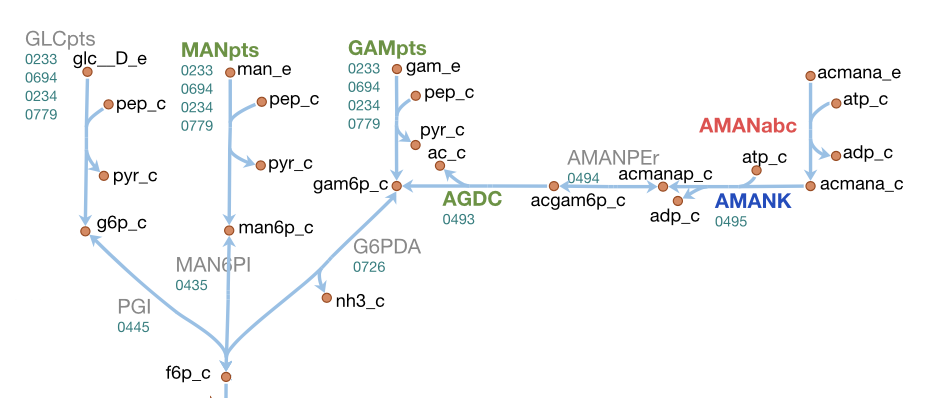

In [23]:
metabolites = ["x_acmana", "acmana", "acmanap", "acgam6p", "gam6p", "x_gam", "x_man", "man6p"]
reactions   = ["AMANabc", "AMANK", "AMANPEr", "AGDC", "G6PDA", "GAMpts", "MANpts", "MAN6PI"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# 7. Final model check and backup <a id="check"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.check_model( test_structure )</code> | Check connectivity issues in the model |
| <code>gba.Builder.summary()</code> | Display a summary of a CGM builder |
| <code>gba.Builder.build_FBA_model()</code> | Reconstruct a FBA model from scratch |
| <code>gba.backup_builder( builder, name, path )</code> | Backup a CGM builder |

</div>

By running a complete test on the model, we see that we did not introduce errors.

In [24]:
builder.check_model(test_structure=True)

❯ Info,No missing mass in the model.


❯ Info,No missing kinetic parameters in the model.


❯ Info,No connectivity issues in the model.


❯ Info,No unproduced metabolites in the model.


❯ Info,No infeasible loops in the model.


❯ Info,No isolated metabolites in the model.


In [25]:
builder.summary()

CGM build JCVI-syn3A summary General 
 
 
 Category 
 Count 
 
 
 
 
 Known proteins 
 461 
 
 
 Modeled proteins 
 178 
 
 
 Metabolites 
 156 
 
 
 Reactions 
 154 
 
 
 Metabolites 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Small molecules 
 133 
 85.26% 
 
 
 Macro-molecules 
 19 
 12.18% 
 
 
 DNA(s) 
 1 
 0.64% 
 
 
 RNA(s) 
 3 
 1.92% 
 
 
 Proteins 
 0 
 0.00% 
 
 
 Unknown 
 0 
 0.00% 
 
 
 Reaction types 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Metabolic 
 119 
 77.27% 
 
 
 Transport 
 18 
 11.69% 
 
 
 Spontaneous 
 17 
 11.04% 
 
 
 Exchange 
 0 
 0.00% 
 
 
 Reaction directions 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Forward 
 97 
 62.99% 
 
 
 Backward 
 1 
 0.65% 
 
 
 Reversible 
 56 
 36.36%

Our modifications led to a slightly decreased growth rate (around 0.33).

In [26]:
builder.build_FBA_model()
fba_sol = sbml_model.optimize()
print("> Reconstructed growth rate:", round(builder.FBA_solution.objective_value, 5), "\n> Original growth rate:     ", round(fba_sol.objective_value, 5))

> Reconstructed growth rate: 0.33154 
> Original growth rate:      0.34239


In [27]:
gba.backup_builder(builder, "mmsyn_build_3", "backup")